# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

You can use `pyarabic` or any other library to pre-process and clean the Arabic text.

In [1]:
# Install necessary libraries
!pip install pyarabic
!pip install nltk
!pip install tensorflow
!pip install keras
!pip install arabicstopwords

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 5.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement arabicstopwords (from versions: none)
ERROR: No matching distribution found for arabicstopwords


In [23]:
# Import libraries
import pandas as pd
import numpy as np
import re
import pyarabic.araby as araby
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Download the Dataset

Please note that you are allowed to take a subset of this dataset, the reason for that is it might take a long time to train the model on.

In [4]:
df = pd.read_csv('sanad.csv')
df.head()

,text,label
0,https://example.com/resource/الشاٌرقة -ْ محمِد...,Culture
1,https://example.com/resource/اَنِطٌلقّتَ ٍفٍيّ...,Culture
2,https://example.com/resource/أُقيًمٌتِ مِساءُ ...,Culture
3,https://example.com/resource/بٍاسُمةَ يًوٌنٍس ...,Culture
4,https://example.com/resource/قُرر اَتحِاد اًلْ...,Culture


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [5]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
text     0
label    0
dtype: int64


In [10]:
# Distribution of labels
label_counts = df['label'].value_counts()
print("\nLabel distribution:")
print(label_counts)


Label distribution:
label
Politics    6334
Medical     6292
Culture     6098
Finance     6095
Tech        5979
Sports      5859
Religion    3228
Name: count, dtype: int64


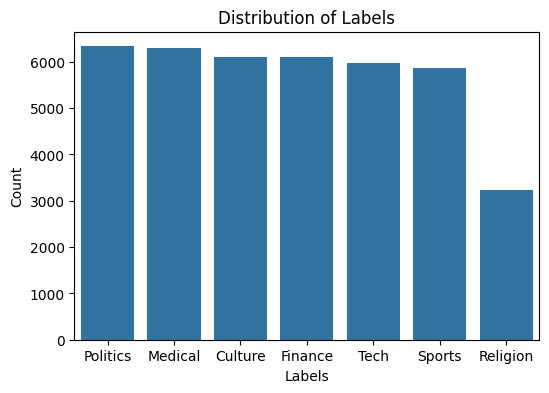

In [11]:
# Plot label distribution
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

In [13]:
# For each label, sample 3000 instances
balanced_df = df.groupby('label').apply(lambda x: x.sample(n=3000, random_state=42)).reset_index(drop=True)

# Check the new label distribution
label_count = balanced_df['label'].value_counts()
print("\nNew Label distribution:")
print(label_count)


New Label distribution:
label
Culture     3000
Finance     3000
Medical     3000
Politics    3000
Religion    3000
Sports      3000
Tech        3000
Name: count, dtype: int64


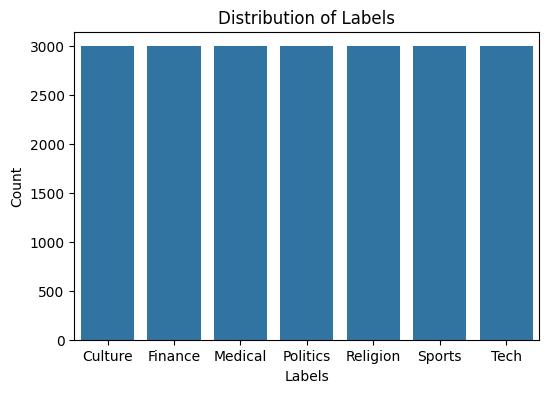

In [14]:
# Plot label distribution
plt.figure(figsize=(6,4))
sns.barplot(x=label_count.index, y=label_count.values)
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

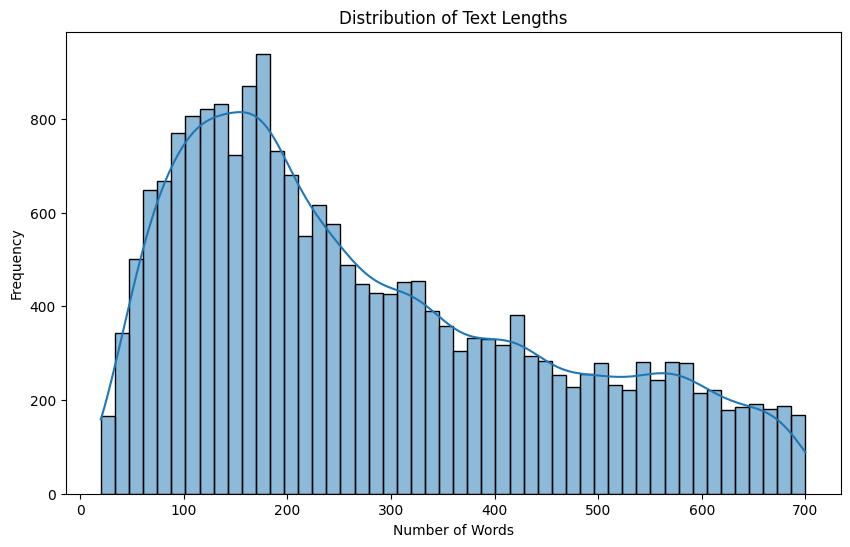

In [15]:
# Analyze text length
balanced_df['text_length'] = balanced_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(balanced_df['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [16]:
# Common words
from collections import Counter
all_words = ' '.join(balanced_df['text']).split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)
print("\nMost common words:")
for word, count in common_words:
    print(f"{word}: {count}")


Most common words:
في: 23849
من: 18150
.: 12149
أن: 6490
على: 5228
عن: 3921
إلى: 3695
ًفي: 3081
ْفي: 3069
فًي: 3062
فُي: 3058
فيِ: 3054
ٌفي: 3043
فٍي: 3040
ٍفي: 3034
فّي: 3029
ِفي: 3027
مع: 3026
فٌي: 3023
َفي: 3014


# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **Arabic stopwords loading**:
   We load a list of Arabic stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   - **Removing links (URLs)**: Any URLs present in the text are removed as they are not meaningful for classification purposes.
   - **Removing special characters and punctuation**: This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   - **Removing Arabic diacritics (Tashkeel) and elongated letters (Tatweel)**: Diacritical marks and elongated letters are stripped out to standardize the text.
   - **Removing Arabic stopwords**: Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   - **Stemming or Lemmmatization**: Either stemming or lemmatization is applied to reduce words to their root or base form.
   - **Normalizing Hamza**: Any variation of the Hamza character is normalized for consistency.

   **Note:** Most of these you can do using the library [PyArabic](https://pyarabic.readthedocs.io/ar/latest/README.html#features)

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [17]:
# Remove missing values
balanced_df.dropna(inplace=True)

# Load Arabic stopwords
arabic_stopwords = set(stopwords.words('arabic'))

# Define text cleaning function
def clean_text(text):
    # Remove links
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove diacritics
    text = araby.strip_tashkeel(text)
    # Remove tatweel
    text = araby.strip_tatweel(text)
    # Normalize Hamza
    text = araby.normalize_hamza(text)
    # Tokenize words
    words = araby.tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in arabic_stopwords]
    # Re-join words
    text = ' '.join(words)
    return text

# Apply the cleaning function to the text column
balanced_df['clean_text'] = balanced_df['text'].apply(clean_text)

# Display cleaned text
balanced_df[['text', 'clean_text']].head()


,text,clean_text
0,https://example.com/resource/اجتمًع مِجِلَس َإ...,مجلس ءدارة اتحاد كتاب وءدباء الءمارات وقرر قبو...
1,https://example.com/resource/يّواًصًلُ مُشَروع...,مشروع كلمة للترجمة هيءة ءبوظبي للسياحة والثقاف...
2,https://example.com/resource/تٍختتًم مؤسِسة اَ...,مءسسة الشارقة للفنون اليوم تجربة مميزة وجديدة ...
3,https://example.com/resource/تُنًظمٍ ِدًاّئرةٍ...,داءرة الثقافة والءعلام الشارقة ضمن ءطار برنامج...
4,https://example.com/resource/وْقَع ًالدكتْور ي...,الدكتور يوسف الحسن كتابه الجديد التنمية الثقاف...


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [18]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_df['clean_text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(balanced_df['clean_text'])

# Define max sequence length
max_length = max(balanced_df['clean_text'].apply(lambda x: len(x.split())))

# Padding the sequences
X = pad_sequences(sequences, maxlen=max_length, padding='post')

# Label encoding
labels = balanced_df['label'].unique().tolist()
label_mapping = {label: idx for idx, label in enumerate(labels)}
balanced_df['label_encoded'] = balanced_df['label'].map(label_mapping)
y = to_categorical(balanced_df['label_encoded'])

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=balanced_df['label_encoded'])

# Data shape confirmation
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (16800, 624)
Training labels shape: (16800, 7)
Testing data shape: (4200, 624)
Testing labels shape: (4200, 7)


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [20]:
# Define model parameters
embedding_dim = 128
lstm_units = 64
num_classes = y.shape[1]

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# Define batch size and epochs
batch_size = 128
epochs = 10

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)


# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[early_stopping])

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - accuracy: 0.3232 - loss: 1.6823 - val_accuracy: 0.9167 - val_loss: 0.3181
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 404s 3s/step - accuracy: 0.9236 - loss: 0.3071 - val_accuracy: 0.9614 - val_loss: 0.1633
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 405s 3s/step - accuracy: 0.9825 - loss: 0.0845 - val_accuracy: 0.9548 - val_loss: 0.2222
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 409s 3s/step - accuracy: 0.9930 - loss: 0.0391 - val_accuracy: 0.9607 - val_loss: 0.2242
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.9926 - loss: 0.0336 - val_accuracy: 0.9629 - val_loss: 0.2160
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 458s 3s/step - accuracy: 0.9978 - loss: 0.0123 - val_accuracy: 0.9640 - val_loss: 0.2616
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.9979 - loss: 0.0109 - val_accuracy: 0.9586 - val_loss: 0.2476


# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

In [26]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 757ms/step - accuracy: 0.9616 - loss: 0.1558

Test Loss: 0.1633019596338272
Test Accuracy: 0.9614285826683044


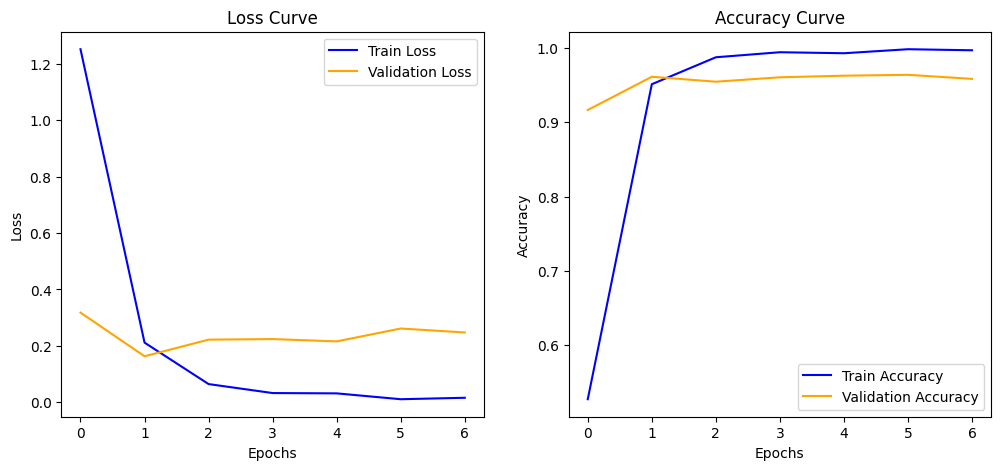

In [27]:
# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [29]:
# Sample text for inference
sample_text = "أحب قراءة كتب سير الصحابة رضي الله عنهم"

# Preprocess the sample text
def preprocess_text(text):
    text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    return padded_sequence

# Preprocess and predict
sample_sequence = preprocess_text(sample_text)
prediction = model.predict(sample_sequence)
predicted_label_idx = np.argmax(prediction, axis=1)[0]
predicted_label = labels[predicted_label_idx]

print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted Label: Religion
